# Lecture 4 Mixture models

# Introduction

In this notebook, Turing is used to cluster data using a Bayesian mixture model. The goal of this task is to use unlabeled data to identify a latent grouping (hidden structure).

A [mixture model](https://en.wikipedia.org/wiki/Mixture_model) is a probabilistic distribution that combines a set of component to represent the overall distribution. Generally, the probability density/mass function is given by a convex combination of the pdf/pmf of individual components, as
\begin{equation}
f_{mix}(x;\Theta,\pi)=\sum_{k=1}^{K}\pi_k f(x;\theta_k)
\end{equation}

A mixture model is characterized by a set of component parameters $\Theta=\{\theta_1, \ldots, \theta_K\}$ and a prior distribution $\pi$ over these components.

An example consists of 2-D data points distributed according to Gaussian distributions.

In [1]:
using Pkg
Pkg.add("Turing")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
   Installed libvorbis_jll ─ v1.3.7+1
  No Changes to `~/.julia/environments/v1.6/Project.toml`
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [f27f6e37] ↑ libvorbis_jll v1.3.7+0 ⇒ v1.3.7+1
Precompiling project...
  ✓ libvorbis_jll
  ✓ FFMPEG_jll
  ✓ FFMPEG
  ✓ GR_jll
  ✓ GR
  ✓ Plots
  ✓ StatsPlots
  7 dependencies successfully precompiled in 89 seconds (274 already precompiled)


In [2]:
Pkg.add("DataFrames")
Pkg.add("CSV")
Pkg.add("MCMCChains")
Pkg.add("Distributions")
Pkg.add("StatsPlots")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [70]:
# loading the library needed
using Turing, DataFrames, CSV
using MCMCChains, Plots, StatsPlots
using Distributions
using Random
using Turing: Variational

In [ ]:
# Prior 
Random.seed!(3)

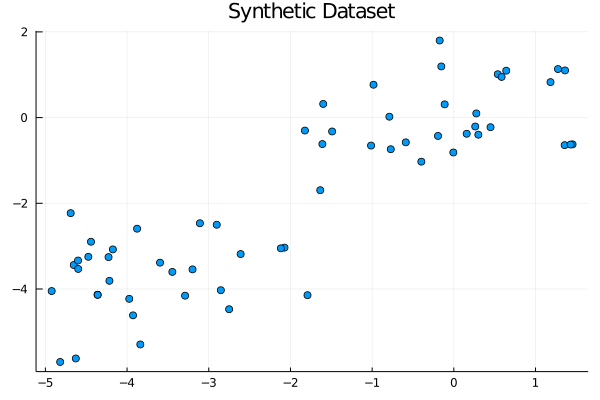

In [98]:
# construct synthetic dataset
# Construct 30 data points for each cluster.
N = 30; 
# Parameters for each cluster, we assume that each cluster is Gaussian distributed in the example.
μ = [-3.5, 0.0]; 
# Construct the data points.
x = mapreduce(c -> rand(MvNormal([μ[c], μ[c]],1.), N), hcat, 1:2);
scatter(x[1,:], x[2,:], legend = false, title = "Synthetic Dataset")

## Gaussian Mixture Model in Turing

To cluster the data points shown above, we use a model that consists of two mixture components (clusters) and assigns each datum to one of the components. The assignment thereof determines the distribution that the data point is generated from.

In particular, in a Bayesian Gaussian mixture model with $1 \leq k \leq K$ components for 1-D data each data point $x_i$ with $1 \leq i \leq N$ is generated according to the following generative process.
First we draw the parameters for each cluster, i.e. in our example we draw location of the distributions from a Normal:
$$
\mu_k \sim \mathrm{Normal}() \, , \;  \forall k
$$
and then draw mixing weight for the $K$ clusters from a Dirichlet distribution, i.e.
$$
    w \sim \mathrm{Dirichlet}(K, \alpha) \, .
$$
After having constructed all the necessary model parameters, we can generate an observation by first selecting one of the clusters and then drawing the datum accordingly, i.e.
$$
    z_i \sim \mathrm{Categorical}(w) \, , \;  \forall i \\
    x_i \sim \mathrm{Normal}(\mu_{z_i}, 1.) \, , \;  \forall i
$$

For more details on Gaussian mixture models, we refer to Christopher M. Bishop, *Pattern Recognition and Machine Learning*, Section 9.

In [100]:
@model GaussianMixtureModel(x) = begin
    
    D, N = size(x)

    # Draw the parameters for cluster 1.
    μ1 ~ Normal()
    
    # Draw the parameters for cluster 2.
    μ2 ~ Normal()
    
    μ = [μ1, μ2]
    
    # Uncomment the following lines to draw the weights for the K clusters 
    # from a Dirichlet distribution.
    
    α = 1.0
    w ~ Dirichlet(2, α)
    
    # Comment out this line if you instead want to draw the weights.
    #w = [0.5, 0.5]
    
    # Draw assignments for each datum and generate it from a multivariate normal.
    k = Vector{Int}(undef, N)
    for i in 1:N
        k[i] ~ Categorical(w)
        x[:,i] ~ MvNormal([μ[k[i]], μ[k[i]]], 1.)
    end
    return k
end

GaussianMixtureModel (generic function with 1 method)

After having specified the model in Turing, we can construct the model function and run a MCMC simulation to obtain assignments of the data points.

To draw observations from the posterior distribution, we use a [particle Gibbs](https://www.stats.ox.ac.uk/~doucet/andrieu_doucet_holenstein_PMCMC.pdf) sampler to draw the discrete assignment parameters as well as a Hamiltonion Monte Carlo sampler for continous parameters.

Note that we use a `Gibbs` sampler to combine both samplers for Bayesian inference in our model.
We are also calling `MCMCThreads` to generate multiple chains, particularly so we test for convergence.

In [106]:
gmm_model = GaussianMixtureModel(x);
gmm_sampler = Gibbs(PG(100, :k), HMC(0.05, 10, :μ1, :μ2, :w))
tchain = sample(gmm_model, gmm_sampler, 100)

Chains MCMC chain (100×65×1 Array{Float64,3}):

Iterations        = 1:100
Thinning interval = 1
Chains            = 1
Samples per chain = 100
parameters        = k[1], k[2], k[3], k[4], k[5], k[6], k[7], k[8], k[9], k[10], k[11], k[12], k[13], k[14], k[15], k[16], k[17], k[18], k[19], k[20], k[21], k[22], k[23], k[24], k[25], k[26], k[27], k[28], k[29], k[30], k[31], k[32], k[33], k[34], k[35], k[36], k[37], k[38], k[39], k[40], k[41], k[42], k[43], k[44], k[45], k[46], k[47], k[48], k[49], k[50], k[51], k[52], k[53], k[54], k[55], k[56], k[57], k[58], k[59], k[60], w[1], w[2], μ1, μ2
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Missing    Float64   Float64 

        k[1]    2.0000    0.0000     0.0000   missing        NaN       NaN
        k[2]    2.0000    0.0000     0.0000   missing        NaN       NaN
        k[3]    2.0000    0.0000     0.0000   missing        N

## Visualize the Density Region of the Mixture Model

After successfully doing posterior inference, we can first visualize the trace and density of the parameters of interest.

In particular, in this example we consider the sample values of the location parameter for the two clusters.


Mean μ1: -0.01764499950548113
Mean μ2: -3.6537614887741285


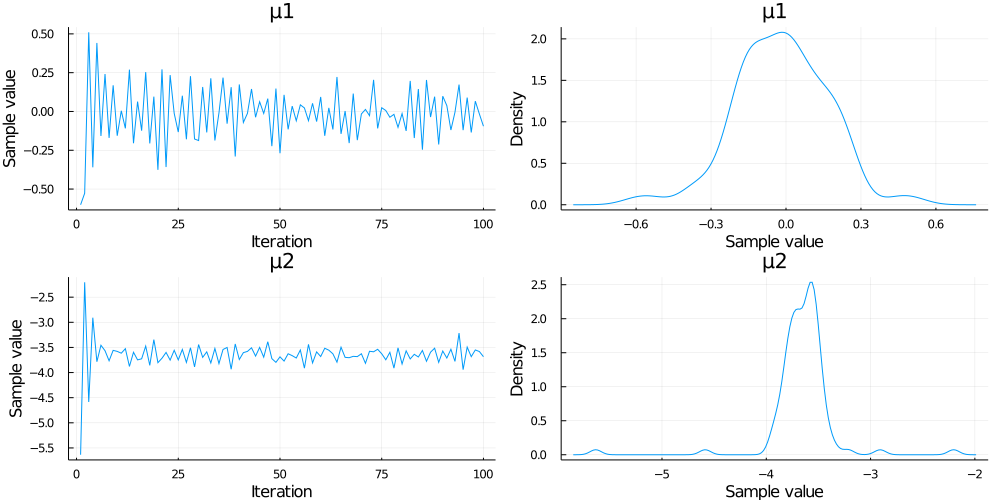

In [110]:
println("Mean μ1: ",mean(tchain[:μ1]))
println("Mean μ2: ",mean(tchain[:μ2]))


plot(tchain[[:μ1, :μ2]])

In [111]:
# Helper function used for visualizing the density region.
function predict(x, y, w, μ)
    # Use log-sum-exp trick for numeric stability.
    return Turing.logaddexp(
        log(w[1]) + logpdf(MvNormal([μ[1], μ[1]], 1.), [x, y]), 
        log(w[2]) + logpdf(MvNormal([μ[2], μ[2]], 1.), [x, y])
    )
end

predict (generic function with 1 method)

## Inferred Assignments

Finally, we can inspect the assignments of the data points inferred using Turing. As we can see, the dataset is partitioned into two distinct groups.


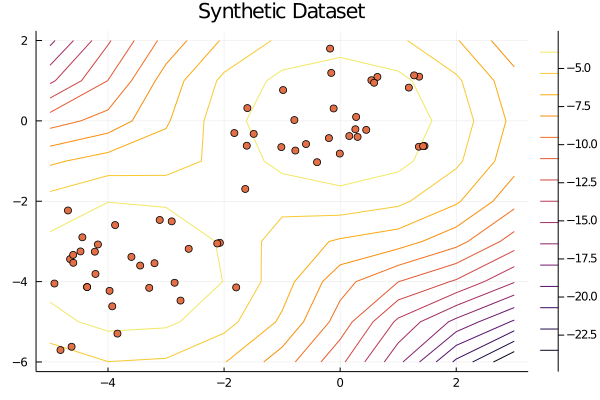

In [112]:
contour(range(-5, stop = 3), range(-6, stop = 2), 
    (x, y) -> predict(x, y, [0.5, 0.5], [mean(tchain[:μ1]), mean(tchain[:μ2])])
)
scatter!(x[1,:], x[2,:], legend = false, title = "Synthetic Dataset")

# Example

The example is about modeling traffic congestion in some part of the road using real sensor data. The dataset is collected in the highway of Los Angeles County in real time by loop detectors. A total of 207 sensors along with their traffic speed from Mar. 1 to Mar. 7, 2012 were selected. The first row of the dataset represents the station where the data is collected and the other rows are the speed of traffic collected every 12 min approximately for about 7 days.

Dataset reference:https://github.com/lehaifeng/T-GCN.

In [73]:
dataset = CSV.read("TrafficSpeed.csv",copycols=true,DataFrame)
dataCol1=dataset[:,1];

## Visualize the traffic congestion

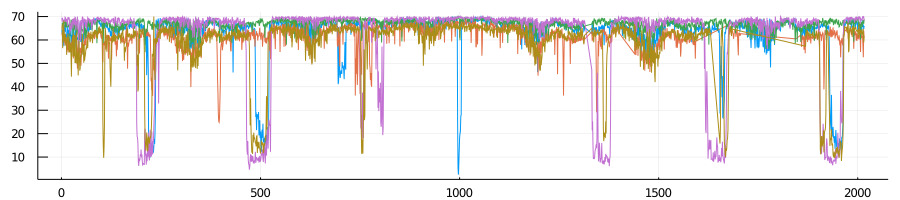

In [74]:
plot(dataset[!,1], size=(900,200),label=false)
plot!(dataset[!,50],label=false)
plot!(dataset[!,100],label=false)
plot!(dataset[!,150],label=false)
plot!(dataset[!,200],label=false)

We can observe common congestion time from the above plots. It also give some hints on the number of clusters for mixture models.

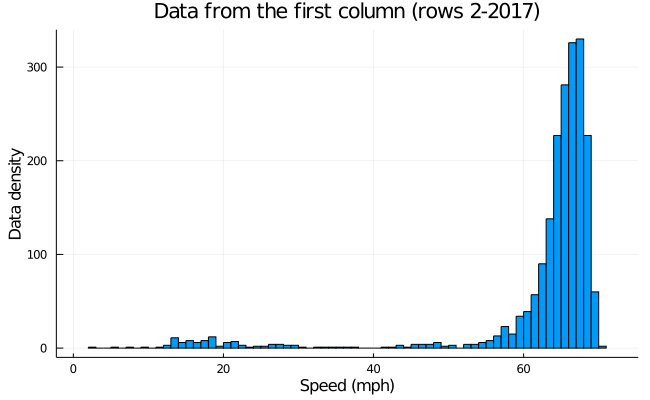

In [75]:
p1 = histogram(dataCol1, title = "Data from the first column (rows 2-2017)", xlabel = "Speed (mph)",label=false)
p = plot(p1, ylabel = "Data density", size = (650,400))

###  Let's implement the model as a single Gaussian model as we studied in previous lectures.
 
Here one single Gaussian model with unknown mean and variance will be implemented for the data from the first column that has multimodal characteristics.

In [76]:
μ0=0
σ0=1/0.001
α0=0.001
β0=1/0.001

x=dataCol1

@model single_gaussian(x) = begin
    μ ~ Normal(μ0, σ0)
    l ~ Gamma(0.5,1)
    x ~ Normal(μ, 1/sqrt(l))
end;

In [77]:
model = single_gaussian(x)
chain = sample(model, NUTS(0.65), 1000)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\Miodrag Bolic\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\Miodrag Bolic\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\Miodrag Bolic\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.0015625
└ @ Turing.Inference C:\Users\Miodrag Bolic\.julia\packages\Turing\O1Pn0\src\inference\hmc.jl:195


Chains MCMC chain (1000×14×1 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = l, μ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

           l    0.0087    0.0003     0.0000    0.0000   983.8944    0.9993
           μ   62.7709    0.2473     0.0078    0.0071   877.6574    0.9992

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           l    0.0082    0.0085    0.0087    0.0089    0.0093
           μ   62.2763   62.6045   62.7739   62.9296   63.2550


(62.76358290420735, 10.728776721400996)

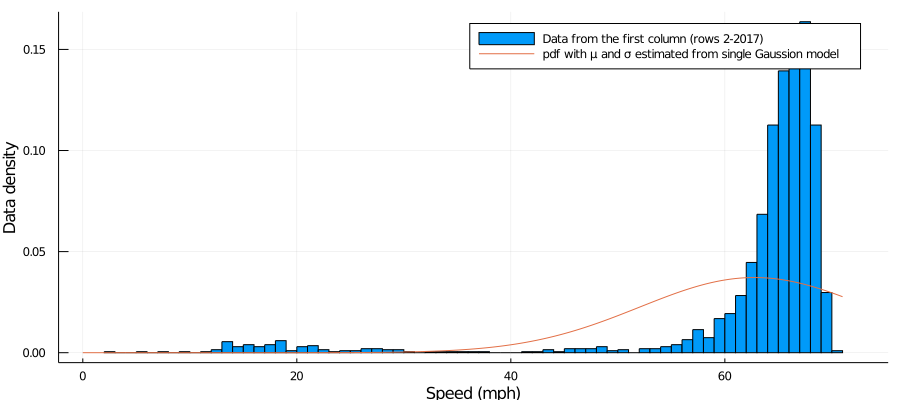

In [78]:
xGrid = 0:0.1:71


dataset = CSV.read("TrafficSpeed.csv",copycols=true,DataFrame)
dataCol1=dataset[:,1];
mu=mean(dataCol1)
si=std(dataCol1)
pdfL(z)=pdf(Normal(mu,si),z)
post_pdfs_2=pdfL.(xGrid)
print((mu,si))

histogram(x, xlabel = "Speed (mph)", ylabel = "Data density", normed=true,label="Data from the first column (rows 2-2017)")
plot!(xGrid, post_pdfs_2, size=(900, 400), label="pdf with μ and σ estimated from single Gaussion model ")

The plot shows that the single Gaussian model could not represent the multimodal characteristics of the data. 

#### Model Checking through multple random replicates

In [79]:
μ=mean(chain[:μ])
σ=mean(chain[:l])
# datatest = rand(Normal(μ, σ), 2016) #unimodal distribution 
datatest = [rand(Normal(μ, σ), 2016) for i = 1:9];

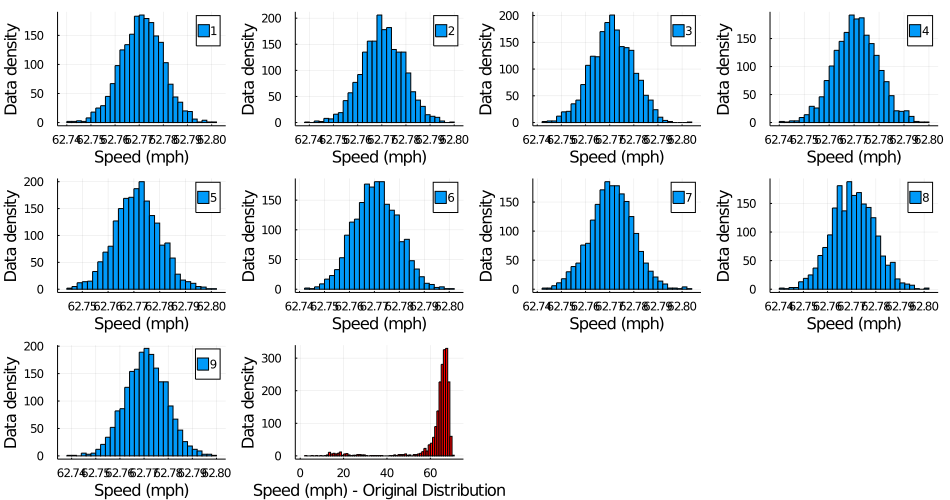

In [80]:
p1=histogram(datatest[1], ylabel = "Data density",xlabel = "Speed (mph)",label="1")
p2=histogram(datatest[2], ylabel = "Data density",xlabel = "Speed (mph)",label="2")
p3=histogram(datatest[3], ylabel = "Data density",xlabel = "Speed (mph)",label="3")
p4=histogram(datatest[4], ylabel = "Data density",xlabel = "Speed (mph)",label="4")
p5=histogram(datatest[5], ylabel = "Data density",xlabel = "Speed (mph)",label="5")
p6=histogram(datatest[6], ylabel = "Data density",xlabel = "Speed (mph)",label="6")
p7=histogram(datatest[7], ylabel = "Data density",xlabel = "Speed (mph)",label="7")
p8=histogram(datatest[8], ylabel = "Data density",xlabel = "Speed (mph)",label="8")
p9=histogram(datatest[9], ylabel = "Data density",xlabel = "Speed (mph)",label="9")
p10=histogram(dataCol1,   ylabel = "Data density", xlabel = "Speed (mph) - Original Distribution",label=false, c=:red)

plot(p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,size=(950, 500))

The histograns in blue are the random replicas and the histogran in red is the original distribution.
Here we can observe that all replicas are diferents of the original distribution. We can conclude that the replicates do not resemble the original data and thus the model has a defect.

Either from the original data histogram or model checking result, it is obviously that one single cluster is not enough for this dataset. There is apparently another cluster nears speed=20 mph, and this Gaussian model will not generate any data around speed=20 according its parameters'(mean and variance) posterior distribution, so this model is not fit enough for this dataset.

#### Mixture model with 2 and 3 clusters.

In [86]:
dataset = CSV.read("TrafficSpeed.csv",copycols=true,DataFrame)
dataCol1=dataset[:,1];

In [93]:
# Mixture model for non-standardized dataset
@model GMM(x,K) = begin
    N = length(x)
    # Prior
    l ~ filldist(Gamma(0.01,100), K)
    μ ~ filldist(Normal(50, 10), K)
    # Draw weights
    w ~ Dirichlet(K, 1)
    # likelihood
    for i in 1:N
        x[i] ~ MixtureModel(Normal, [(μ[k], (1/sqrt(l[k]))) for k = 1:K], w)
    end

end
model_2k=GMM(dataCol1,2)
model_3k=GMM(dataCol1,3)

DynamicPPL.Model{var"#71#73",(:x, :K),(),(),Tuple{Array{Float64,1},Int64},Tuple{}}(:GMM, var"#71#73"(), (x = [64.375, 62.66666667, 64.0, 61.77777778, 59.55555556, 57.33333333, 66.5, 63.625, 68.75, 63.5  …  64.625, 65.44444444, 63.125, 62.875, 68.375, 65.55555556, 66.625, 66.375, 64.66666667, 66.0], K = 3), NamedTuple())

In [94]:
chain_2k=sample(model_2k, NUTS(100,0.95), 300)

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference C:\Users\Miodrag Bolic\.julia\packages\Turing\O1Pn0\src\inference\hmc.jl:195


Chains MCMC chain (300×18×1 Array{Float64,3}):

Iterations        = 1:300
Thinning interval = 1
Chains            = 1
Samples per chain = 300
parameters        = l[1], l[2], w[1], w[2], μ[1], μ[2]
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

        l[1]    0.2057    0.0091     0.0005    0.0006   200.6961    0.9967
        l[2]    0.0027    0.0003     0.0000    0.0000   166.5808    0.9979
        w[1]    0.8846    0.0089     0.0005    0.0009   272.1757    0.9967
        w[2]    0.1154    0.0089     0.0005    0.0009   272.1757    0.9967
        μ[1]   65.7554    0.0589     0.0034    0.0015   399.1252    0.9974
        μ[2]   39.9789    2.2240     0.1284    0.41

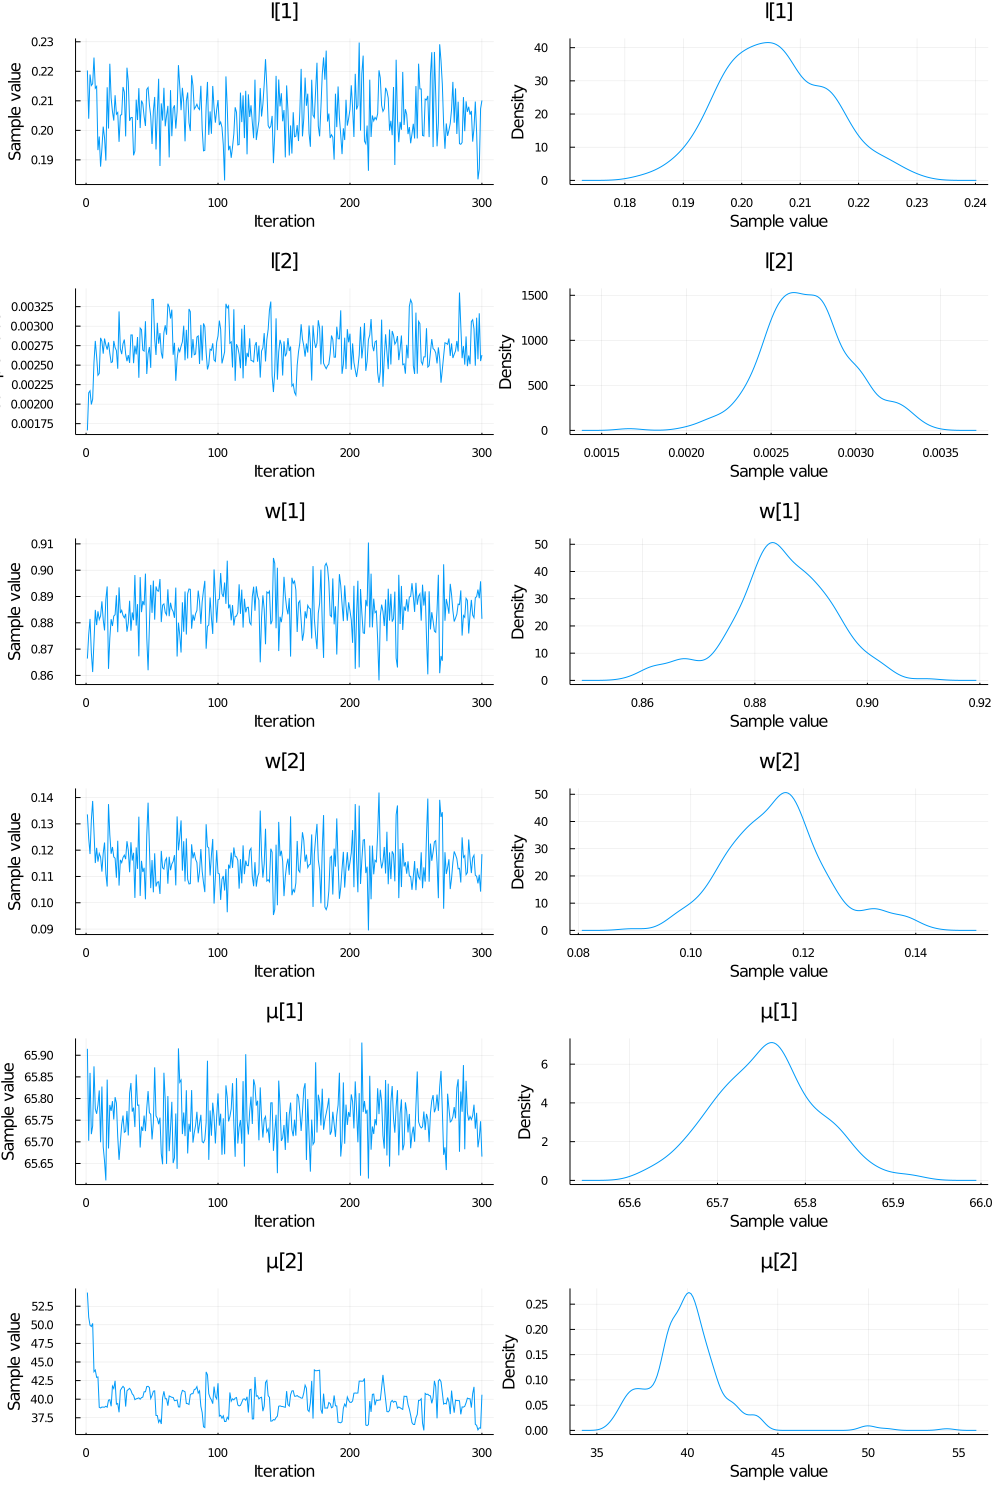

In [95]:
plot(chain_2k)

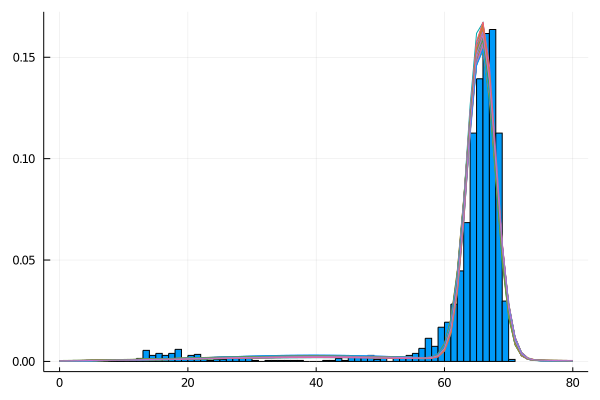

In [90]:
# Visualized the result of the 2-cluster mixture model
p = get_params(chain_2k)

x_ = 0:80
post_pdfs_1=[pdf(Normal(p.μ[1][s], 1/sqrt(p.l[1][s])), x) * p.w[1][s] for x = x_, s = 150:200]
post_pdfs_2=[pdf(Normal(p.μ[2][s], 1/sqrt(p.l[2][s])), x) * p.w[2][s] for x = x_, s = 150:200]
    
histogram(dataCol1,normed=true,label=false)
plot!(x_, post_pdfs_1 + post_pdfs_2, label=false)

In [96]:
# Distribution of means and viariances of the 2-cluster model
p1=density(p.μ[1],label="μ1")
p2=density(p.μ[2],label="μ2")

p3=density(p.l[1],label="σ1")
p4=density(p.l[2],label="σ2")

plot(p1,p2,p3,p4 layout=(2,2), size=(900,300))

LoadError: syntax: missing comma or ) in argument list

We can observe that GMM model with 2 and 3 clusters fit the data.